### <span style='font-family:Georgia'> The purpose
Recommending the most popular movies among similar users that the user did not watch.

### <span style='font-family:Georgia'> The method
Compute the similarity between the user identified with the `user_id` given while initializing the object (passed to the constructor) and every other user.
Then predict the ratings of movies. The ratings are calculated using a weighted average of the ratings of films by other users, where the weights are equal to the similarity of two users. The similarity is computed based on the pearson correlation scaled to $[0,1]$ interval.

In [24]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [25]:
import os
import re
from collections import Counter
from typing import List, Dict
from tqdm.notebook import tqdm

import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import random

random.seed(10)

In [26]:
class RecommenderSystem:
    def __init__(self, user_id: int, n_similar: int, min_common: int):
        self.user_id = user_id
        self.n_similar = n_similar
        self.min_common = min_common
        self.features = self.__extract_features()
        self.similar_users = []

    @staticmethod
    def __transform_data_to_dict(data: List[str]) -> Dict[int, Dict]:
        """Function for transforming a line of input text data to a dict"""
        _data = [l.split(",") for l in data]
        return {int(movie_id): int(rating) for movie_id, rating, date in _data}

    def __extract_features(self) -> Dict[int, Dict]:
        """Extract movies, ratings and dates for this specific user"""
        data: List[str] = []
        condition = False
        for fname in PATHS:
            with open(fname) as f:
                for line in f:
                    l = line.strip()
                    if re.match(r"\d+:", line):
                        if condition:
                            return self.__transform_data_to_dict(data)
                        elif re.match(re.compile(f"{self.user_id}:"), l):
                            condition = True  # if this is the user id we are looking for, start collecting
                        else:
                            continue
                    else:
                        if condition:
                            data.append(l)
        return __transform_data_to_dict(data)

    def compute_users_similarity(
        self, user1_preferences: Dict[int, Dict], user2_preferences: Dict[int, Dict]
    ) -> float:
        """Compute the similarity based on the correlation between ratings of movies"""
        common = set(user1_preferences.keys()).intersection(user2_preferences.keys())
        common = [x for x in common if x < LIMIT_MOVIES_CNT]
        if len(common) < self.min_common:
            return 0.0
        intersection1 = [user1_preferences[k] for k in common]
        intersection2 = [user2_preferences[k] for k in common]
        return float((pearsonr(intersection1, intersection2)[0] + 1) / 2)

    def get_similar_users(self) -> Dict:
        """
        Function for:
            1. parsing the file line by line,
            2. computing pairwise similarity between users,
            3. if high, saving the user, similarity score and preferences
        """
        highly_similar_user_id = None
        data: List[str] = []
        for file_name in PATHS:
            with open(file_name) as f:
                for line in f:
                    line = line.strip()
                    if re.match(r"\d+:", line):
                        if highly_similar_user_id:
                            features = self.__transform_data_to_dict(data)
                            similarity = self.compute_users_similarity(
                                self.features, features
                            )
                            self.similar_users += [
                                {
                                    "user": highly_similar_user_id,
                                    "similarity": similarity,
                                    "movies": features,
                                }
                            ]
                        highly_similar_user_id = int(re.findall(r"(\d+):", line)[0])
                        if highly_similar_user_id > LIMIT_USERS_CNT:
                            return self.similar_users
                        data = []
                    else:
                        if highly_similar_user_id != self.user_id:
                            data.append(line)
        return self.similar_users

    def recommend(self) -> Dict:
        """
        Function recommending the most popular movies
        among similar users that the user did not watch.
        """
        similar_users = self.get_similar_users()
        weighted_avg = {}
        for preferences in tqdm(similar_users):
            for movie_id, rating in preferences["movies"].items():
                if movie_id not in weighted_avg:
                    weighted_avg[movie_id] = [0] * 3  # numerator, denominator, count
                weighted_avg[movie_id][0] += rating * preferences["similarity"]
                weighted_avg[movie_id][1] += preferences["similarity"]
                weighted_avg[movie_id][2] += 1
        result = {
            movie_id: value[0] / value[1] if value[0] > 1e-13 else 0
            for movie_id, value in weighted_avg.items()
            if value[2] > self.min_common
        }
        return result


In [56]:
USER_ID = 1
N_SIMILAR = 5
MIN_COMMON = 10
PATHS = [
    os.path.join("./data/netflix", "combined_data_{}.txt".format(i + 1))
    for i in list(range(4))
]

LIMIT_USERS_CNT = 1000  # limit for shortening calculation time (modifiable parameter)
LIMIT_MOVIES_CNT = float(
    "inf"
)  # limit for shortening calculation time (modifiable parameter, here: no limit)


In [78]:
# Test

# initialize the RecommenderSystem instance
r = RecommenderSystem(user_id=USER_ID, n_similar=N_SIMILAR, min_common=MIN_COMMON)

# get a list of movies and a the ratings for the user given by USER_ID
user_features = list(r.features.keys())

# split the dictionary into test and train subsets, for the further evaluation
train, test = train_test_split(user_features)
test_features = {k: v for k, v in r.features.items() if k in test}
r.features = {k: v for k, v in r.features.items() if k in train}

# calculate the recommendation
recommended = r.recommend()
recommended_series = pd.DataFrame(
    recommended.items(), columns=["movie", "recommendation"]
).sort_values("recommendation", ascending=False)

# evaluate (compare the recommendation with actual user's preferences from test set)
recommended_series["test_rating"] = recommended_series["movie"].map(test_features)
recommended_series[~recommended_series["test_rating"].isna()]


  0%|          | 0/1000 [00:00<?, ?it/s]

,movie,recommendation,test_rating
104402,400162,5.000000,5.0
114759,1782762,4.824521,4.0
28138,685565,4.810960,5.0
39,1664010,4.672587,5.0
109519,208920,4.515629,4.0
...,...,...,...
13114,1009622,2.488926,1.0
881,1935793,2.418749,1.0
16020,1878798,2.378989,4.0
14596,1777406,2.272923,3.0


In [85]:
np.abs(np.mean(recommended_series[~recommended_series["test_rating"].isna()]["recommendation"] - recommended_series[~recommended_series["test_rating"].isna()]["test_rating"]))

0.3695652173913043

In [86]:
np.mean((recommended_series[~recommended_series["test_rating"].isna()]["recommendation"] - recommended_series[~recommended_series["test_rating"].isna()]["test_rating"]) ** 2)

1.1956521739130435

In [87]:
recommended_series["recommendation"] = recommended_series["recommendation"].round()

In [88]:
np.mean(recommended_series[~recommended_series["test_rating"].isna()]["recommendation"] == recommended_series[~recommended_series["test_rating"].isna()]["test_rating"])

0.34782608695652173

## Some EDA

References: https://www.kaggle.com/code/fanglidayan/10-netflix-movie-recommender-part-1

In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from collections import deque

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "./data/netflix"

In [3]:
movie_titles = pd.read_csv(os.path.join(path, "movie_titles.csv"),
                           encoding = 'ISO-8859-1',
                           usecols=range(3),
                           lineterminator='\n',
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')
movie_titles.head(5)

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [4]:
movie_titles.shape

(17770, 2)

In [5]:
ratings = [pd.read_csv(os.path.join(path, f"combined_data_{i}.txt"), 
                       header=None,
                       names=["User", "Rating", "Date"],
                       usecols=range(3))
           for i in range(1, 2)]


In [6]:
df_raw = pd.concat(ratings).reset_index(drop=True)

In [7]:
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index() # make the original index a new column
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

user_data = []

In [8]:
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

In [9]:
df = pd.concat(user_data)
print('Shape User-Ratings:\t{}'.format(df.shape))
display(df.sample(10))


Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
12684224,1535702,3.0,2005-07-22,2430
7904968,750677,2.0,2003-05-25,1585
3065054,918842,4.0,2005-11-25,571
10807399,1054253,5.0,2004-02-23,2114
21795104,2231380,3.0,2005-01-20,4123
8067563,135878,3.0,2003-08-14,1615
1883599,923889,2.0,2004-04-11,353
18233186,1138060,5.0,2004-06-26,3466
2397271,318052,4.0,2005-10-14,457
9397,901555,5.0,2005-07-11,8


Text(0.5, 1.0, 'Number of Movies Released in a Year')

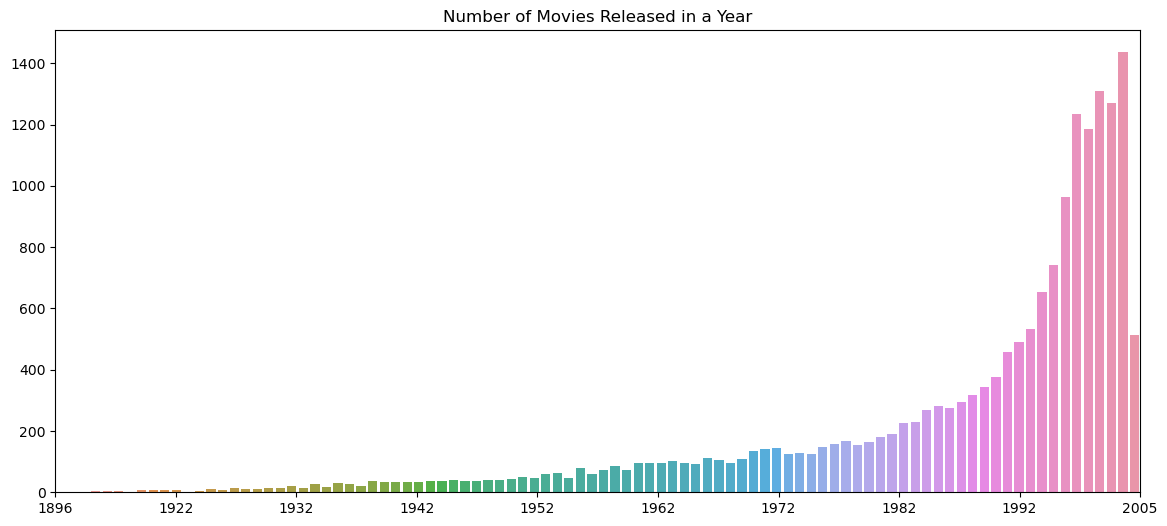

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x=x, y=y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels)
plt.title("Number of Movies Released in a Year")

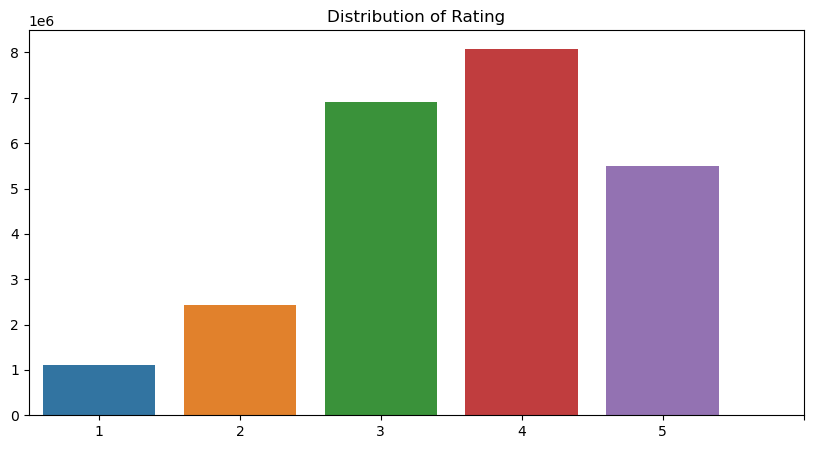

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x=x, y=y)
xmin, xmax = plt.xlim()
plt.xticks(ticks=[0,1,2,3,4,5]);
plt.title("Distribution of Rating")

del fig, ax, data, x, y, xmin, xmax

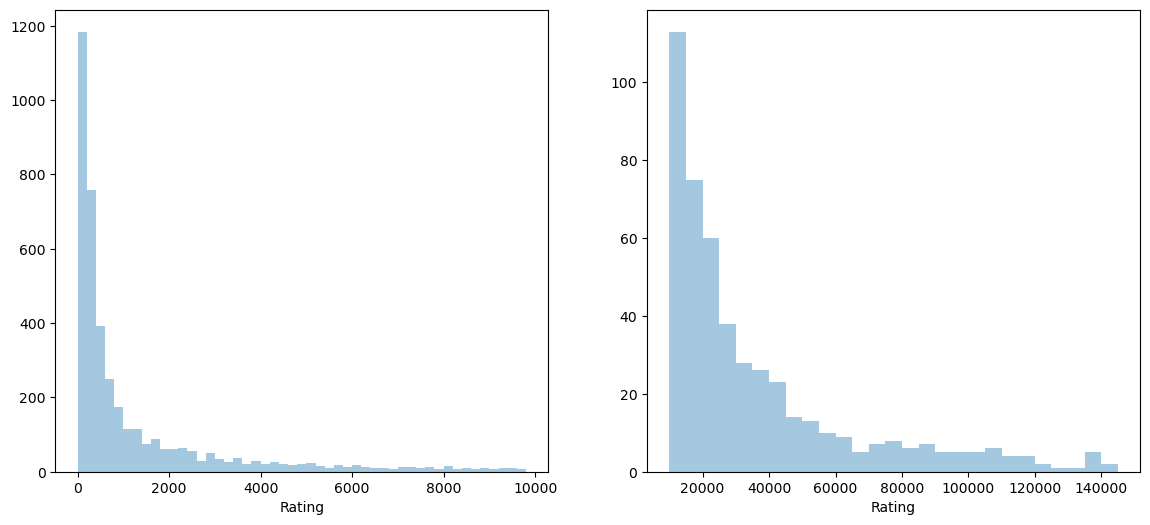

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0], bins=[i for i in range(0,10000,200)]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1], bins=[i for i in range(10000,150000,5000)]);

del fig, ax, data

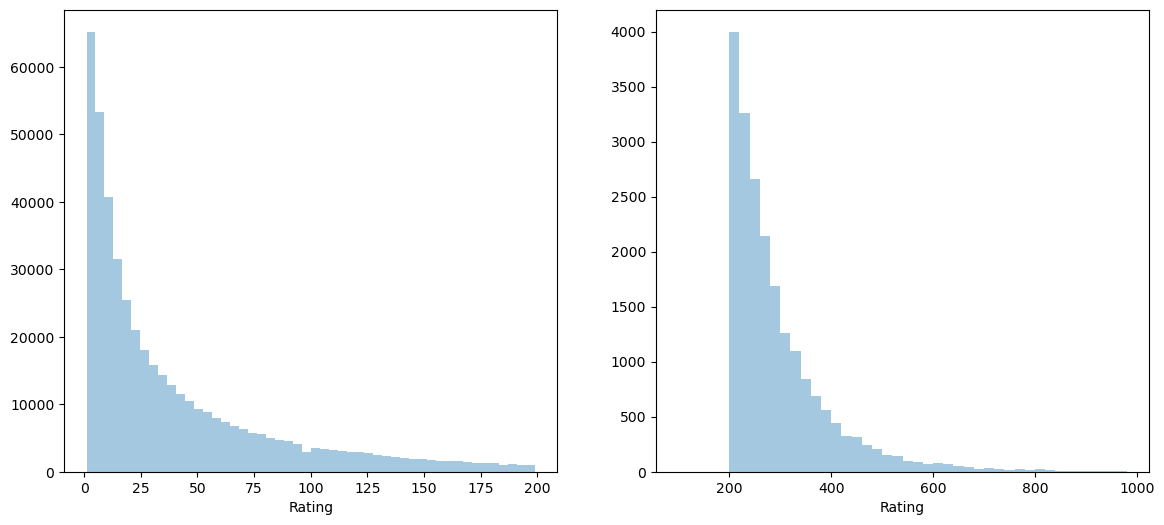

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('User')['Rating'].count()
sns.distplot(data[data  < 200], kde=False, ax=ax[0]);
sns.distplot(data[data  > 200], kde=False, ax=ax[1], bins=[i for i in range(100,1000,20)]);

del fig, ax, data